https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb 

In [109]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import numpy as np
import os

from sklearn.metrics import accuracy_score,f1_score,precision_score
from torchsummaryX import summary
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import wandb

wandb.init(project="milestone2_resnet34")

f1,▁▃▃▄▅▆▇▇██
loss,█▆▆▅▄▃▂▂▁▁
precision,▁▂▃▃▄▆▇▇██
val_f1,▁▇▇▇▇▇█████
val_loss,█▂▂▂▂▂▁▁▁▁▁
val_precision,▁█▇▇▇▇█████
f1,0.958
loss,0.05721
precision,0.973
val_f1,0.79
val_loss,0.22376


In [111]:
#data_dir = './data/lfw'
data_dir = '/data_seoul/dain5832/cmu/summer/celebA/celeba'

batch_size = 128
epochs = 10
workers = 0 if os.name == 'nt' else 8

wandb.config.batch_size = batch_size
wandb.config.epochs = epochs

In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## InceptionResnetV1

In [113]:
class InceptionResnetV1_multilabel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #self.resnet = InceptionResnetV1(
        #    classify=True,
        #    pretrained='vggface2',
        #    num_classes=n_classes
        #)
        self.resnet = models.resnet34(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = InceptionResnetV1_multilabel(40).to(device)

In [114]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)
scheduler = MultiStepLR(optimizer, [5, 10])

wandb.config.lr = 0.001
wandb.config.optim = 'Adam'
wandb.config.weight_decay = 1.2e-6

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='valid', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [115]:
loss_fn = torch.nn.BCEWithLogitsLoss()
metrics = {
    
}

In [116]:
def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={}, show_running=True,
    device='cpu', writer=None
):
    """Train or evaluate over a data epoch.
    
    Arguments:
        model {torch.nn.Module} -- Pytorch model.
        loss_fn {callable} -- A function to compute (scalar) loss.
        loader {torch.utils.data.DataLoader} -- A pytorch data loader.
    
    Keyword Arguments:
        optimizer {torch.optim.Optimizer} -- A pytorch optimizer.
        scheduler {torch.optim.lr_scheduler._LRScheduler} -- LR scheduler (default: {None})
        batch_metrics {dict} -- Dictionary of metric functions to call on each batch. The default
            is a simple timer. A progressive average of these metrics, along with the average
            loss, is printed every batch. (default: {{'time': iter_timer()}})
        show_running {bool} -- Whether or not to print losses and metrics for the current batch
            or rolling averages. (default: {False})
        device {str or torch.device} -- Device for pytorch to use. (default: {'cpu'})
        writer {torch.utils.tensorboard.SummaryWriter} -- Tensorboard SummaryWriter. (default: {None})
    
    Returns:
        tuple(torch.Tensor, dict) -- A tuple of the average loss and a dictionary of average
            metric values across the epoch.
    """
    
    mode = 'Train' if model.training else 'Valid'
    logger = training.Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    history = {'loss':[], 'f1':[], 'acc':[], 'precision':[], 'val_loss':[], 'val_f1':[], 'val_acc':[], 'val_precision':[]}
    y_preds, targets = [], []
    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        prediction=torch.round(torch.sigmoid(y_pred))
        y_preds.append(prediction.detach().cpu())
        targets.append(y.detach().cpu())
        loss_batch = loss_fn(y_pred.to(torch.float32), y.to(torch.float32))

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            if metric_name == 'fps':
                metrics_batch[metric_name] = metric_fn(y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()).detach().cpu()
                metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            else:
                threshold = 0.5
                y_pred = np.array(y_pred.detach().cpu().numpy() > threshold, dtype=float)
                #print(y_pred)
                #print(y)
                metrics_batch[metric_name] = metric_fn(y_pred.astype(int), y.detach().cpu().numpy().astype(int))
                metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
        
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
    f1=round(f1_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    acc=round(accuracy_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy()), 3)
    precision = round(precision_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    
    print('f1score:', f1)
    print('precision:', precision)
    if model.training:
        history['loss'].append(loss)
        history['f1'].append(f1)
        history['acc'].append(acc)
        history['precision'].append(precision)
        wandb.log({"loss": loss, "f1": f1, "precision":precision})

    else:
        history['val_loss'].append(loss)
        history['val_f1'].append(f1)
        history['val_acc'].append(acc)
        history['val_precision'].append(precision)
        wandb.log({"val_loss": loss, "val_f1": f1, "val_precision":precision})
    
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics, history

In [117]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
pass_epoch(
    model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    pass_epoch(
        model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    torch.save(model.state_dict(), 'model_{}.pth'.format(epoch))

writer.close()



Initial
----------
Valid |    32/32   | loss:    0.7602 |    
f1score: 0.325
precision: 0.228

Epoch 1/10
----------
Train |   125/125  | loss:    0.2558 |    
f1score: 0.702
precision: 0.81
Valid |    32/32   | loss:    0.2769 |    
f1score: 0.707
precision: 0.733

Epoch 2/10
----------
Train |   125/125  | loss:    0.2080 |    
f1score: 0.761
precision: 0.842
Valid |    32/32   | loss:    0.2382 |    
f1score: 0.745
precision: 0.773

Epoch 3/10
----------
Train |   125/125  | loss:    0.1886 |    
f1score: 0.787
precision: 0.855
Valid |    32/32   | loss:    0.2197 |    
f1score: 0.752
precision: 0.833

Epoch 4/10
----------
Train |   125/125  | loss:    0.1719 |    
f1score: 0.809
precision: 0.868
Valid |    32/32   | loss:    0.2271 |    
f1score: 0.752
precision: 0.793

Epoch 5/10
----------
Train |   125/125  | loss:    0.1546 |    
f1score: 0.831
precision: 0.88
Valid |    32/32   | loss:    0.2238 |    
f1score: 0.77
precision: 0.783

Epoch 6/10
----------
Train |   125/125  

## Test

In [76]:

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
#dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='test', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)

test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds)
)

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

df_attr = pd.read_csv('/data_seoul/dain5832/cmu/summer/celebA/celeba/list_attr_celeba.txt', delim_whitespace=True, header=1)
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


40


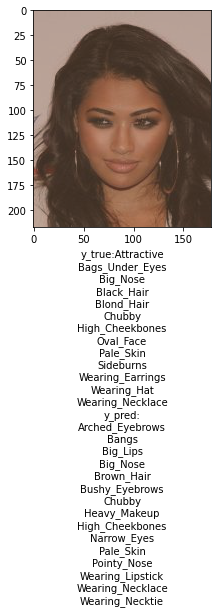

In [40]:
for (images, attr) in test_loader:
    idx= 0
    y_pred = model(images.to(device))
    prediction=torch.round(torch.sigmoid(y_pred)).detach().cpu()

    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    prediction = prediction[idx].numpy().astype(int)
    print(len(prediction))
    preds = ""
    for label,a in list(zip(labels,prediction)):
        if a== 1:
            preds+= "\n"+label
    labels="\n".join([label for label,a in list(zip(labels,att)) if a==1])
    #preds = "\n".join([label for label,a in list(zip(labels,prediction)) if a==1])
    plt.xlabel("y_true:"+labels+"\n"+"y_pred:"+preds)
    plt.show()
    break